#  Co-Affiliation networks

In [1]:
from maa.network.network import create_networks_from_config
from maa.config.utils import configure_logging, LogLevel
from maa.config.constants import CONFIGURATION_PATH
import maa.constants.constants as constants
import pandas as pd
from maa.network.utils import create_graph_from_edges
import matplotlib.pyplot as plt
import networkx as nx
from maa.plot.utils import apply_affiliation_aliases
from maa.constants.constants import ORG_TYPE_FILTER_LIST
from maa.utils.utils import filter_organization_types
configure_logging(level=LogLevel.WARNING)
%load_ext autoreload
%autoreload 2

## Create co-affiliation networks from the configuration

This step constructs the networks using the file paths and parameters defined in the configuration
file. The configuration specifies where the input data is located and how both the unfiltered (`CoAffAll`)
and filtered (`CoAffStable`) co-affiliation networks should be created.

A default configuration file can be generated using the CLI command `create-default-config`
(implemented in [`create_default_config.py`](../src/maa/cli/create_default_config.py)
 and exposed as a Poetry entry point).


In [2]:
networks = create_networks_from_config(config_path=CONFIGURATION_PATH)
unfiltered_network = networks.all
filtered_network   = networks.stable

# link GeoDataFrames
link_gdf_all = unfiltered_network.link_gdf
link_gdf_stable = filtered_network.link_gdf

# edge GeoDataFrames
edge_gdf_all = filter_organization_types(df=unfiltered_network.graph.edge_gdf, org_types=ORG_TYPE_FILTER_LIST)
edge_gdf_stable = filter_organization_types(df=filtered_network.graph.edge_gdf, org_types=ORG_TYPE_FILTER_LIST)

2025-12-19T08:15:34.534917Z Dropped 246 affiliation link(s) from the DataFrame with no coordinates.


## Basic statistics
The cell below summarizes the number of link records and edge records in both the unfiltered (`CoAffAll`) and filtered (`CoAffStable`) co-affiliation networks. As expected, the filtered dataset contains fewer links and edges.

In the stable dataset, the minimum edge strength is 2, which matches the filtering criterion defined in the configuration file. This means that the temporal filter retains only those institution pairs that were co-affiliated by the same author in at least two different years, with a gap of ≥ 2 years between the earliest and latest co-affiliation events.

In [3]:
stats_df = pd.DataFrame(
    {
        "N. link records": [
            len(link_gdf_all),
            len(link_gdf_stable),
        ],
        "N. edge records": [
            len(edge_gdf_all),
            len(edge_gdf_stable),
        ],
         "Min edge strength": [
            edge_gdf_all[constants.AFFILIATION_EDGE_COUNT_COLUMN].min(),
            edge_gdf_stable[constants.AFFILIATION_EDGE_COUNT_COLUMN].min(),
        ],
        "Max edge strength": [
            edge_gdf_all[constants.AFFILIATION_EDGE_COUNT_COLUMN].max(),
            edge_gdf_stable[constants.AFFILIATION_EDGE_COUNT_COLUMN].max(),
        ],
    },
    index=["Unfiltered (all data)", "Filtered (stable data)"],
)

stats_df.style.format(lambda x: f"{x:,.0f}".replace(",", " "))

,N. link records,N. edge records,Min edge strength,Max edge strength
Unfiltered (all data),44 298,3 087,1,3 120
Filtered (stable data),29 881,896,2,3 018


The cell below shows a preview of the unfiltered (all data) co-affiliation link GeoDataFrame

In [4]:
# Select columns for readability
unfiltered_links = link_gdf_all.sort_values(by=[constants.DOI_COLUMN, constants.ARTICLE_AUTHOR_ID_COLUMN])
columns = [
    constants.COVER_DATE_COLUMN,
    constants.DOI_COLUMN,
    constants.PREFERRED_AFFILIATION_NAME_COLUMN,
    f'{constants.PREFERRED_AFFILIATION_NAME_COLUMN}_to',
    constants.ORGANISATION_TYPE_COLUMN,
    f'{constants.ORGANISATION_TYPE_COLUMN}_to'
]
unfiltered_links[columns].head()

,cover_date,doi,preferred_name,preferred_name_to,org_type,org_type_to
633,2013-02-27,10.1001/jama.2013.905,Medizinische Universität Graz,Ludwig Boltzmann Gesellschaft Wien,uni,res
634,2013-02-27,10.1001/jama.2013.905,Medizinische Universität Graz,Ludwig Boltzmann Gesellschaft Wien,uni,res
4598,2014-10-15,10.1001/jama.2014.13204,Medizinische Universität Graz,Schilddrüsen Endokrinologie Osteoporose Instit...,uni,med
13749,2017-05-02,10.1001/jama.2017.4039,Johannes Kepler Universität Linz,Austrian Institute of Technology Wien,uni,res
30103,2020-12-01,10.1001/jamacardio.2020.3377,Sigmund Freud Privatuniversität,Klinik Ottakring,uni,med


## Unfiltered (`CoAffAll`) vs. filtered (`CoAffStable`) data
The cell below filters low-strength edges from the `CoAffAll` dataset

In [5]:
edges_strength_1 = edge_gdf_all[
    edge_gdf_all[constants.AFFILIATION_EDGE_COUNT_COLUMN] <= 1
]

edges_strength_1[columns].head()

,cover_date,doi,preferred_name,preferred_name_to,org_type,org_type_to
26,2013-01-01,10.1007/s00464-013-3071-8,Paracelsus Medizinische Privatuniversität,Tauernklinikum Standort Zell am See und Stando...,uni,med
39,2013-01-01,10.1515/jetl-2013-0017,Austrian Constitutional Court,The Austrian Supreme Court,gov,gov
50,2013-01-01,10.1007/s11082-012-9603-y,Johannes Kepler Universität Linz,KAI Kompetenzzentrum für Automobil- und Indust...,uni,comp
58,2013-01-01,10.1016/j.autneu.2013.08.065,Universität Wien,Research Group Functional Rehabilitation and G...,uni,res
61,2013-01-01,10.2174/1573413711309030002,Johannes Kepler Universität Linz,TIGER Coatings GmbH & Co. KG,uni,comp


To verify whether low-strength edges from the unfiltered dataset appear in the filtered (`CoAffStable`) dataset, we merge both edge tables on their node pairs. The resulting _merge column contains only "left_only", confirming that none of the low-strength edges are present in the filtered network—as expected from the temporal filtering rule.

In [6]:
# Merge low-strength edges (from "all") with the stable dataset
merged = edges_strength_1.merge(
    edge_gdf_stable,
    on=[constants.FROM_NODE_COLUMN, constants.TO_NODE_COLUMN],
    how="left",
    indicator=True,
    suffixes=("", "_merged"),
)

# Assert that all low-strength edges are absent from the stable dataset
assert (merged["_merge"] == "left_only").all()

# Show preview of the result
merged[columns + ["_merge"]].head()


,cover_date,doi,preferred_name,preferred_name_to,org_type,org_type_to,_merge
0,2013-01-01,10.1007/s00464-013-3071-8,Paracelsus Medizinische Privatuniversität,Tauernklinikum Standort Zell am See und Stando...,uni,med,left_only
1,2013-01-01,10.1515/jetl-2013-0017,Austrian Constitutional Court,The Austrian Supreme Court,gov,gov,left_only
2,2013-01-01,10.1007/s11082-012-9603-y,Johannes Kepler Universität Linz,KAI Kompetenzzentrum für Automobil- und Indust...,uni,comp,left_only
3,2013-01-01,10.1016/j.autneu.2013.08.065,Universität Wien,Research Group Functional Rehabilitation and G...,uni,res,left_only
4,2013-01-01,10.2174/1573413711309030002,Johannes Kepler Universität Linz,TIGER Coatings GmbH & Co. KG,uni,comp,left_only


The low-strength edges are not expected to appear in the filtered (`CoAffStable`) dataset. This is correct and follows directly from the temporal filtering rule described above: only institution pairs that co-occurred in publications by the same author in at least two different years, separated by a gap of ≥ 2 years, are retained. Consequently, edges with strength 1 are excluded from the filtered network by design.

In [7]:
# Check explicitly whether any of the low-strength edges appear in the stable network
present_in_stable = merged[merged["_merge"] == "both"]
present_in_stable.head()

# Assert that there are none
assert len(present_in_stable) == 0

## Plot Co-Affiliation Graph

This visualization shows the largest connected component of the co-affiliation network,
where nodes represent institutions (after alias harmonization) and edges represent
co-affiliation relationships between them. Only edges with a minimum strength
(i.e., co-affiliation count) of `min_edge_strength` are included. The ARF layout
is used to produce a clean, cluster-separating arrangement of the graph.

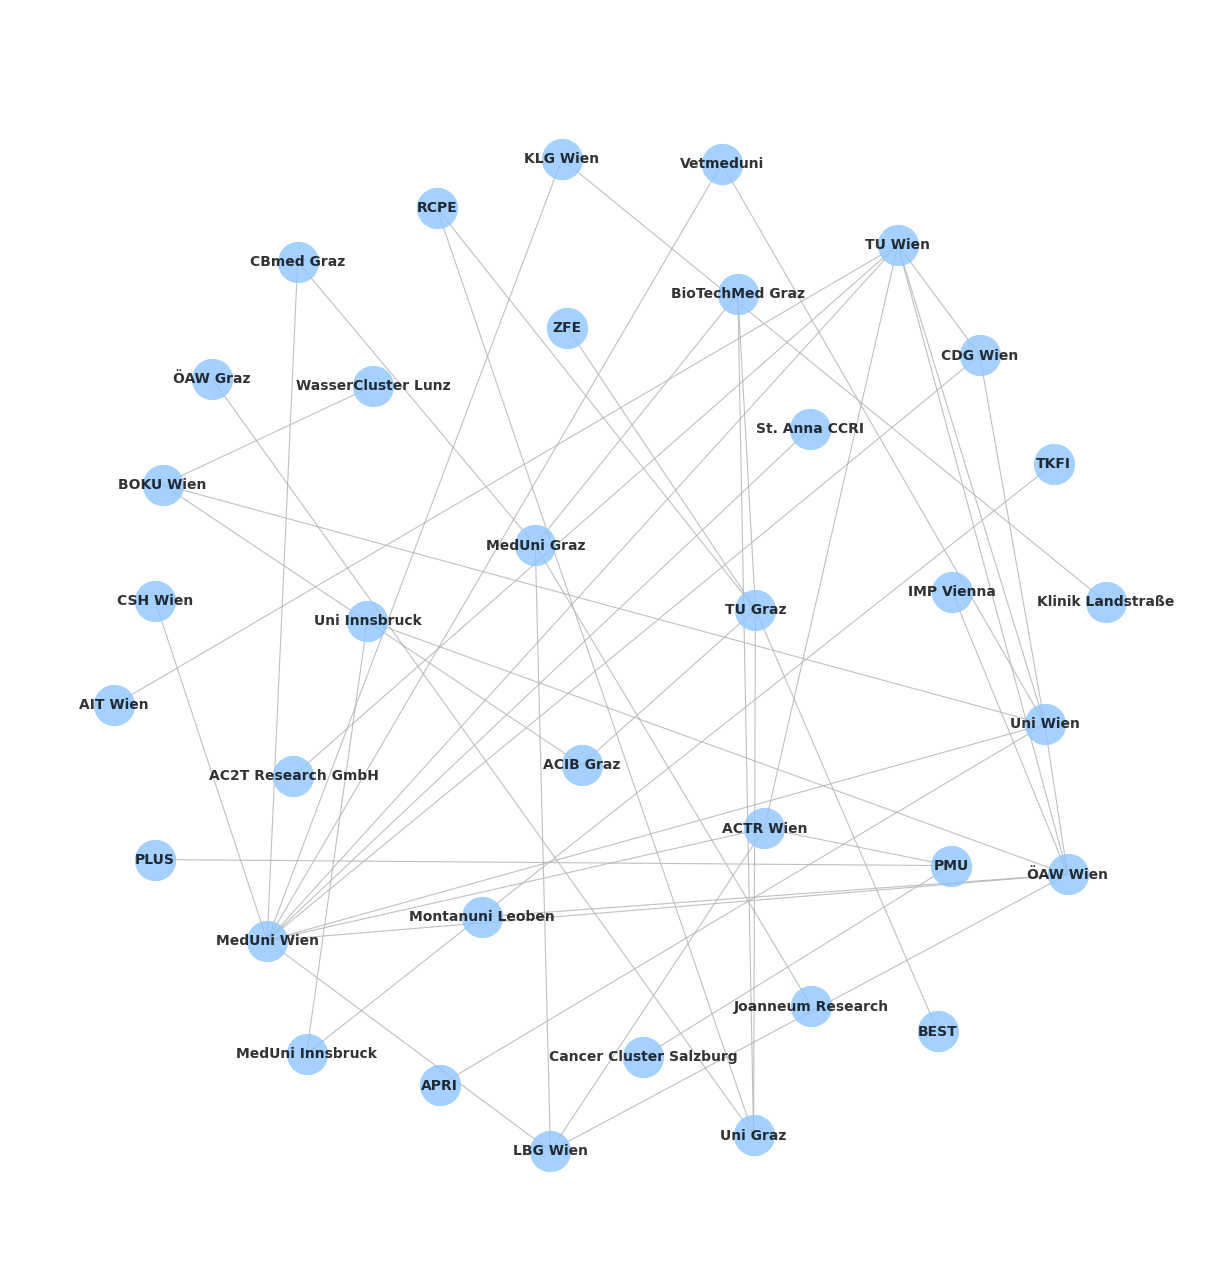

In [8]:
# constants
from_node = constants.PREFERRED_AFFILIATION_NAME_COLUMN
to_node   = f"{from_node}_to"
min_edge_strength = 100

# preprocess affiliation aliases
apply_affiliation_aliases(df=edge_gdf_stable, column=from_node)
apply_affiliation_aliases(df=edge_gdf_stable, column=to_node)

# build graph
graph_filtered = create_graph_from_edges(
    edge_gdf=edge_gdf_stable,
    from_node_column=from_node,
    to_node_column=to_node,
    weight_column=constants.AFFILIATION_EDGE_COUNT_COLUMN,
    min_weight=min_edge_strength,
)

# restrict to the largest connected component
G = graph_filtered
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc)

# layout
pos = nx.arf_layout(G)

# plot
plt.figure(figsize=(12, 12))

nx.draw(
    G,
    pos=pos,
    node_color="#8EC6FF",   # soft blue
    edge_color="#B0B0B0",   # gentle gray
    node_size=850,
    alpha=0.80,
    linewidths=0.5,
    width=0.8,
    with_labels=True,
    font_size=10,
    font_weight="bold",
)

plt.title(
    f"Co-Affiliation Network (Largest Connected Component)\n"
    f"Minimum Edge Strength = {min_edge_strength}",
    fontsize=14,
    weight="bold"
)
plt.axis("off")
plt.show()


